## BUILDING A MOVIE RECOMMENDATION SYSTEM 

Group Members:

1. Mwangi Wambugu

2. Grace Mutuku

3. Rony Muriithi 

4. Esther Nyawera

5. John Kioko

6. Heri Kimotho

7. Peter Otieno

### OBJECTIVES

1. To analyse the data and find the highest rated movies based on the data provided.
2. To analyse the data and find the highest rated genres based on the data provided.
3. Create a recommendation system that makes movie recommendations based on user ratings by suggesting products that resonate with user’s past ratings.


### OVERVIEW
1. Importing Libraries and Loading Data
2. Data Understanding
3. Exploratory Data Analysis
4. Modeling




### 1. IMPORTING LIBRARIES AND LOADING DATA

In [1]:
# Importing the relevant libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from surprise import Reader, Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_and_join_csv(file_path_1, file_path_2):
    # Load CSV files into Pandas DataFrames
    movies = pd.read_csv(file_path_1)
    ratings = pd.read_csv(file_path_2)
        
    # Perform inner joins to combine the datasets based on common column movieId
    movies_ratings_df = pd.merge(movies, ratings, on='movieId', how='inner')
      
    return movies_ratings_df

# Replace  with your actual file paths
movie_rating_df = load_and_join_csv("ml-latest-small/movies.csv", "ml-latest-small/ratings.csv")

# Display the resulting dataset
movie_rating_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


### 2. DATA UNDERSTANDING

The dataset contains 6 columns and 100,836 entries. The 6 columns are `movieId`, `title`, `genres`, `userId`, `rating` and `timestamp`

In [3]:
def examine_data(df):
    # Display the shape, columns and the first few rows of the dataset
    print("----------------------------Details about the data----------------------------\n ")
    print("----------------------------Shape of the dataset---------------------------- ")
    print(f"The dataset is a DataFrame with {df.shape[0]} rows and {df.shape[1]} columns\n")
    print("----------------------------Columns of the dataset---------------------------- ")
    display(df.columns)
    print("---------------------------- First 5 records of the dataset---------------------------- ")
    display(df.head())
    # Display information about the dataset
    print("\n----------------------------Data information ----------------------------")
    display(df.info())
    print("\n----------------------------Null Values ----------------------------")
    display(df.isnull().sum())
    print("\n----------------------------Duplicate Values ----------------------------")
    print(df.duplicated().sum(), 'duplicate values')
    return df
          
              
# Replace with your dataframe
df = examine_data(movie_rating_df)

----------------------------Details about the data----------------------------
 
----------------------------Shape of the dataset---------------------------- 
The dataset is a DataFrame with 100836 rows and 6 columns

----------------------------Columns of the dataset---------------------------- 


Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

---------------------------- First 5 records of the dataset---------------------------- 


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483



----------------------------Data information ----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


None


----------------------------Null Values ----------------------------


movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


----------------------------Duplicate Values ----------------------------
0 duplicate values


### 3. EXPLORATORY DATA ANALYSIS
A brief statistical summary below of the numerical data provides insight into the distribution of the data by providing an overview of its central tendency and spread. In data ananlsis we look at the different components that make up the dataset. The insight will greatly inform the modelling. For our analysis we will start by looking for information of the structure and distribution of the dataset.

In [4]:
def data_analysis(df):
    display(df.describe())
    print('-------------Data Details---------------')
    print(f'Number of unique users:', movie_rating_df.userId.nunique())
    print(f'Number of unique movies:', movie_rating_df.movieId.nunique())

data_analysis(movie_rating_df)

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


-------------Data Details---------------
Number of unique users: 610
Number of unique movies: 9724


### 3.1 UNIVARIATE DATA ANALYSIS
#### 3.1.1 COUNT PLOTS

After the initial analysis we jump right into plotting the different columns in the dataset to see the distribution. We will do this by first doing a univariate analysis which will be looking at the distributions of individual columns. The columns we have singled out are: rating, title.

In [5]:

# A function to create plots
def create_plots(df, plot_type, columns_to_plot = None, y = None):
    if plot_type == 'count_plot':
        plt.figure(figsize=(12,8))
        sns.countplot(data=df, x=columns_to_plot)
        plt.title(f'Distribution of movie {columns_to_plot}')
        plt.xticks(rotation=90)
        plt.show()
    elif plot_type == 'bar_plot1':
        plt.figure(figsize=(12, 7))
        sns.barplot(columns_to_plot.index, columns_to_plot.values)
        plt.title('Top 10 most frequently rated movies')
        plt.xlabel('Movie tile')
        plt.xticks(rotation=90)
        plt.ylabel('Count')
        plt.show()
    elif plot_type == 'bar_plot2':
        plt.figure(figsize=(12, 7))
        sns.barplot(columns_to_plot.index, columns_to_plot.values)
        plt.title('Top 10 most frequently rated movies and their average ratings')
        plt.xlabel('Movie tile')
        plt.xticks(rotation=90)
        plt.ylabel('Average Rating')
        plt.show()

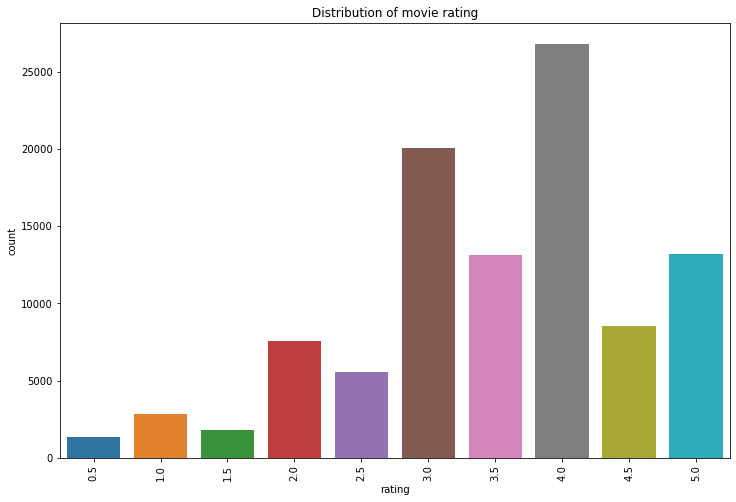

In [6]:
create_plots(movie_rating_df, 'count_plot', 'rating')

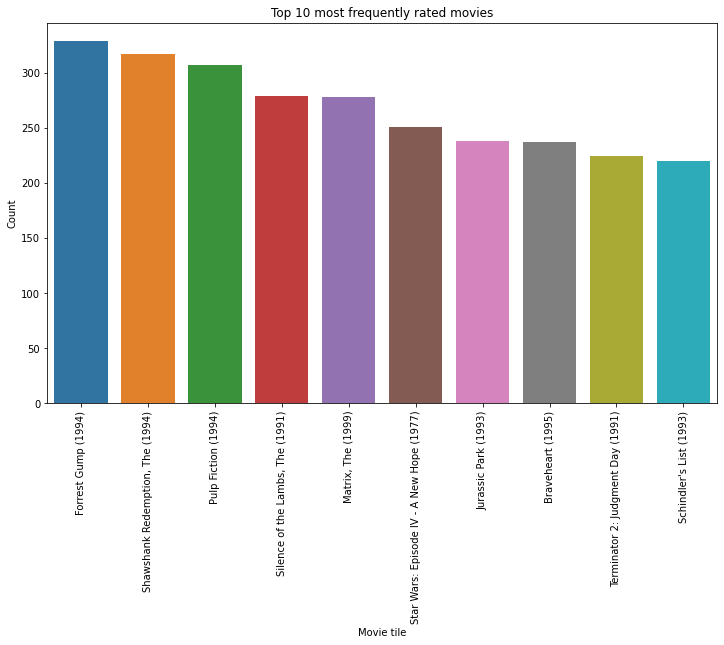

In [7]:
top_10_views = movie_rating_df['title'].value_counts().head(10)

create_plots(movie_rating_df, 'bar_plot1', top_10_views)

From the analysis conducted we find that most movies are rated at a 4 on a scale of 1 to 5 and the most popular movie is Forrest Gump(1994). This indicates that most users are having a good user experience so far with the current recommendations. The next step is would be to plot a graph indicating the most popular genres. 

In [8]:
# Splitting the genres
def splitting_string(movies):
    movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
    from collections import Counter
    genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
    
    return genre_frequency

splitting_string(movie_rating_df)

Counter({'Adventure': 24161,
         'Animation': 6988,
         'Children': 9208,
         'Comedy': 39053,
         'Fantasy': 11834,
         'Romance': 18124,
         'Drama': 41928,
         'Action': 30635,
         'Crime': 16681,
         'Thriller': 26452,
         'Horror': 7291,
         'Mystery': 7674,
         'Sci-Fi': 17243,
         'War': 4859,
         'Musical': 4138,
         'Documentary': 1219,
         'IMAX': 4145,
         'Western': 1930,
         'Film-Noir': 870,
         '(no genres listed)': 47})

Next, we create a copy of the dataset to preserve the original dataset to ensure reproducibility and easy testing and debugging.After which we join all the columns i nto a single dataset so we can start our univariate analysis.

In [9]:
exploded_genres_df = movie_rating_df.copy()
exploded_genres_df = exploded_genres_df.explode('genres')
exploded_genres_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure,1,4.0,964982703
0,1,Toy Story (1995),Animation,1,4.0,964982703
0,1,Toy Story (1995),Children,1,4.0,964982703
0,1,Toy Story (1995),Comedy,1,4.0,964982703
0,1,Toy Story (1995),Fantasy,1,4.0,964982703
...,...,...,...,...,...,...
100832,193583,No Game No Life: Zero (2017),Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action,184,3.5,1537110021
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Animation,184,3.5,1537110021


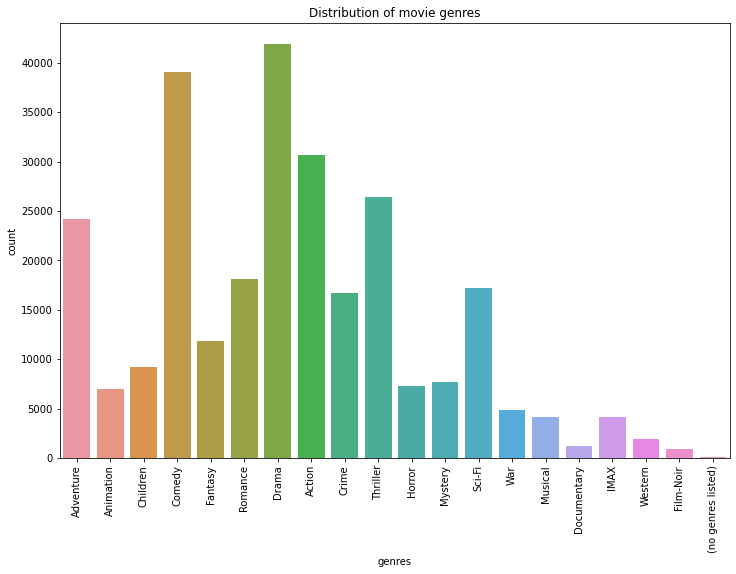

In [10]:
create_plots(exploded_genres_df, 'count_plot', 'genres')

### 3.1.2 BIVARIATE DATA ANALYSIS

Bivariate analysis is used to explore the relationship between two variables. It involves the simultaneous analysis of two variables to understand the patterns of their variation, co-variation, and potential relationships. The primary goal of bivariate analysis is to uncover patterns, associations, and dependencies between the two variables being studied. 

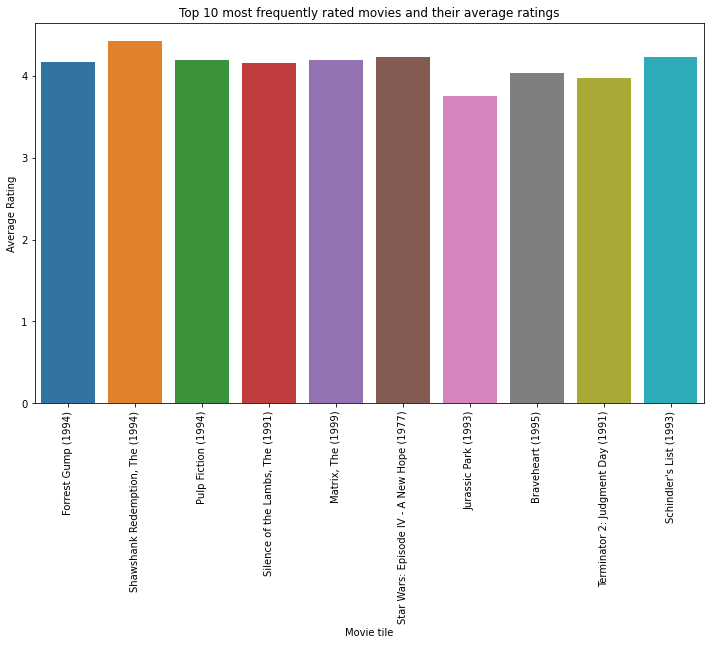

In [11]:
top_10_views = movie_rating_df['title'].value_counts().nlargest(10)
average_ratings = movie_rating_df.groupby('title')['rating'].mean().loc[top_10_views.index]


create_plots(movie_rating_df, 'bar_plot2', average_ratings)

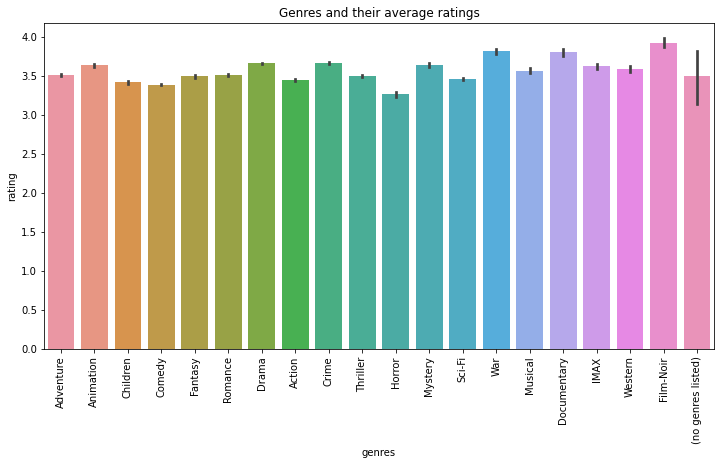

In [12]:
def bar_plot(x, y, data):
    
    plt.figure(figsize=(12,6))
    
    sns.barplot(x=x, y=y, data=data)
    plt.title('Genres and their average ratings')
    plt.xlabel(f'{x}')
    plt.xticks(rotation=90)
    plt.ylabel(f'{y}')
    plt.show()

bar_plot('genres', 'rating', exploded_genres_df)

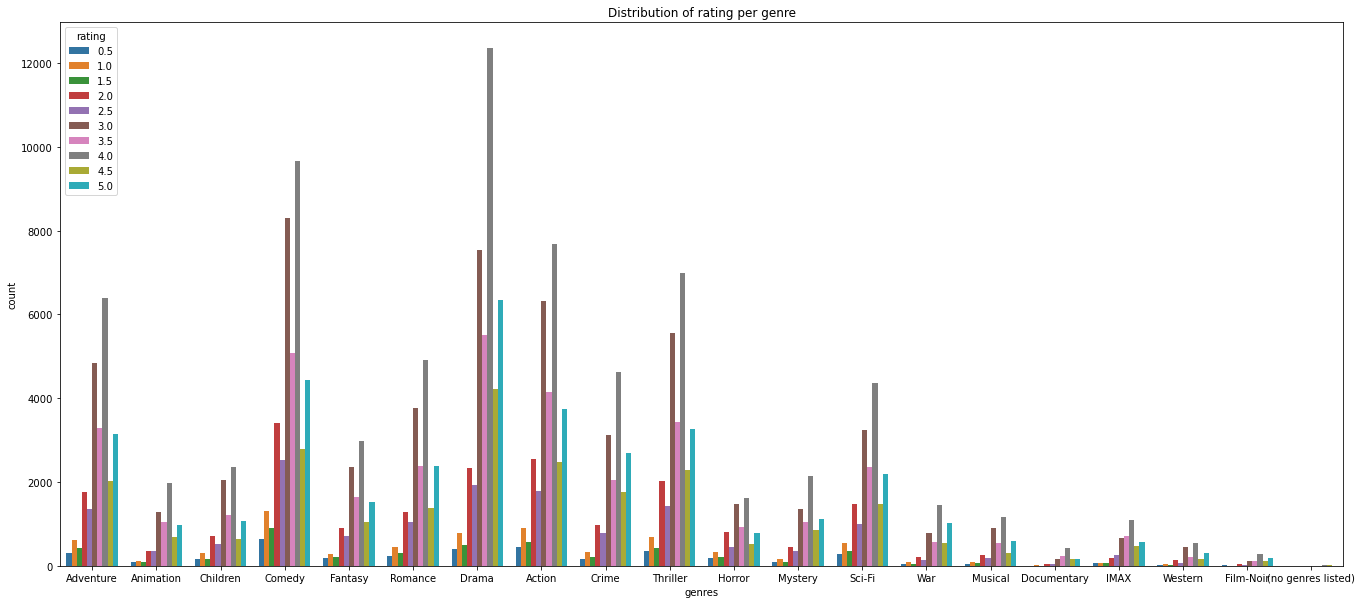

In [26]:
plt.figure(figsize=(23,10))
sns.countplot(data=exploded_genres_df, x='genres', hue='rating')
plt.title(f'Distribution of rating per genre')
plt.show()

In [27]:
def sort_movie_ratings(movie, order):
    mean_rating = movie.groupby('title')[['rating']].mean()
    mean_rating_sorted = mean_rating['rating'].sort_values(ascending=False)
    if order == 'top':
        ranked_movies = mean_rating_sorted.head(20)
    elif order == 'bottom':
        ranked_movies = mean_rating_sorted.tail(20)
    return ranked_movies

print("......The top 20 highest rated movies........\n", sort_movie_ratings(movie_rating_df, 'top'))
print("\n.....The bottom 20 lowest rated movies....\n", sort_movie_ratings(movie_rating_df, 'bottom'))

......The top 20 highest rated movies........
 title
Karlson Returns (1970)                               5.0
Winter in Prostokvashino (1984)                      5.0
My Love (2006)                                       5.0
Sorority House Massacre II (1990)                    5.0
Winnie the Pooh and the Day of Concern (1972)        5.0
Sorority House Massacre (1986)                       5.0
Bill Hicks: Revelations (1993)                       5.0
My Man Godfrey (1957)                                5.0
Hellbenders (2012)                                   5.0
In the blue sea, in the white foam. (1984)           5.0
Won't You Be My Neighbor? (2018)                     5.0
Red Sorghum (Hong gao liang) (1987)                  5.0
Love Exposure (Ai No Mukidashi) (2008)               5.0
My Sassy Girl (Yeopgijeogin geunyeo) (2001)          5.0
The Love Bug (1997)                                  5.0
Ballad of Narayama, The (Narayama bushiko) (1983)    5.0
Heidi Fleiss: Hollywood Madam (1995

From the analysis we find that Shawshank Redemption is the most ratings. This is an average of all the ratings.The ratings for the genres is higher in film noir which is stylized Hollywood crime dramas, particularly those that emphasize cynical attitudes and motivations. The 1940s and 1950s are generally regarded as the "classic period" of American film noir. The last model was a comparison across the different film genres where the drama genre had the highest ratings.

## 4. MODELING
The technique used is collaborative filtering which is based on the proposition that similar people like similar things.

In [28]:
# Select the necessary columns from the dataset 
user_item_df = movie_rating_df[['userId', 'movieId', 'rating']]

# Transform the pandas dataframe into Surprise dataset 
reader = Reader()
data = Dataset.load_from_df(user_item_df, reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=111)

# Print the number of unique users and items in the dataset
print("Number of users: ", trainset.n_users, "\n")
print("Number of items: ", trainset.n_items, "\n")

Number of users:  610 

Number of items:  8995 



### MODELING FUNCTIONS

In [29]:
# Function to create the model
def model_creation(approach, trainset, testset):
    if approach == SVD:
        model = approach(n_factors= 50, reg_all=0.05, random_state = 111)
        model.fit(trainset)
        print(f'{approach.__name__} RMSE:', accuracy.rmse(model.test(testset)))
    else:    
        model = approach(sim_options={'name':'pearson', 'user_based':True},  random_state=111)
        model.fit(trainset)
        print(f'{approach.__name__} RMSE:', accuracy.rmse(model.test(testset)))   



# Function to perform Grid Search
def param_grid_search(model_to_tune): 
    
    # Setting relevant parameters for Gridsearch
    grid = {
        'k': [30, 40],   # Number of neighbors
        'sim_options': {
            'name': ['cosine', 'pearson'],  # Similarity measures
            'user_based': [True],  # User-based collaborative filtering
        },
    }
    # Creating a parameter grid search for SVD model
    params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1],
        #  'n_epochs': [5,10],
        # 'lr_all': [0.002,0.005]
         }

    # Running grid search with the defined parameter grid
    if model_to_tune == SVD:
        grid_search = GridSearchCV(model_to_tune, params,
                                    measures=['rmse'], n_jobs=-1)
    else:
        grid_search = GridSearchCV(model_to_tune, grid,
                                    measures=['rmse'], n_jobs=-1)
    grid_search.fit(data)
    print(f"Best RMSE for {model_to_tune.__name__}: {grid_search.best_score}")
    print(f"Best Hyperparameters for {model_to_tune.__name__}: {grid_search.best_params}")

    

### MODEL 1: KNN BASIC MODEL

In [30]:
# Build a KNNBasic model
model_creation(KNNBasic, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9721
KNNBasic RMSE: 0.9720846164183417


#### Tune the KNNBasic Model

In [31]:
# Grid search for KNNBasic Model
param_grid_search(KNNBasic)

Best RMSE for KNNBasic: {'rmse': 0.9704841583753282}
Best Hyperparameters for KNNBasic: {'rmse': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}}


### MODEL 2: KNNBaseline Model

In [32]:
# Build a KNNBaseline model
model_creation(KNNBaseline, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8790
KNNBaseline RMSE: 0.8789611074934803


#### Tune the KNNBaseline Model

In [33]:
# Grid search for KNNBaseline Model
param_grid_search(KNNBaseline)

Best RMSE for KNNBaseline: {'rmse': 0.8766760663182571}
Best Hyperparameters for KNNBaseline: {'rmse': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}}


### MODEL 3: KNNWithMeans Model

In [34]:
# Build a KNNWithMeans model
model_creation(KNNWithMeans, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8995
KNNWithMeans RMSE: 0.8994971701396823


#### Tune the KNNWithMeans Model

In [35]:
# Grid search for KNNWithMeans Model
param_grid_search(KNNWithMeans)

Best RMSE for KNNWithMeans: {'rmse': 0.8963874970572963}
Best Hyperparameters for KNNWithMeans: {'rmse': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}}


### MODEL 4: SVD Model

In [36]:
# Build a SVD model
model_creation(SVD, trainset, testset)

RMSE: 0.8709
SVD RMSE: 0.8709079093151322


In [37]:
# Grid search for KNNWithMeans Model
param_grid_search(SVD)

Best RMSE for SVD: {'rmse': 0.8688117835927092}
Best Hyperparameters for SVD: {'rmse': {'n_factors': 50, 'reg_all': 0.05}}


### FINAL MODEL SELECTION AND EVALUATION

SVD model performed best as compared to the rest of the models with a RMSE of 0.8688. This means that, on average, the predicted ratings are about 0.8688 units away from the actual ratings. 

In [38]:
# A table that displays a summary of the validation metrics
def make_evaluation_table(metrics_dict):
    metrics_df = pd.DataFrame(metrics_dict)
    evaluation_table = metrics_df.to_html(index=False)
    return evaluation_table

metrics_dict = {
    'Model': ['KNNBasic', 'KNNBaseline', 'KNNWithMeans', 'SVD'],
    'RMSE': [0.9721, 0.8790, 0.8995, 0.8709],
    'RMSE after Tuning': [0.9705, 0.8767, 0.8964, 0.8688],
    }

evaluation_table = make_evaluation_table(metrics_dict)
HTML(evaluation_table)


Model,RMSE,RMSE after Tuning
KNNBasic,0.9721,0.9705
KNNBaseline,0.8790,0.8767
KNNWithMeans,0.8995,0.8964
SVD,0.8709,0.8688


In [39]:
# Final model selected
final_model = SVD(n_factors= 50, reg_all=0.05, random_state=111)
final_model.fit(trainset)

### PREDICTIONS

In [40]:
# A function to ask the user to rate movies they have watched
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

# A function to rank the movies in the database based on the user's rating on presented movies
def rank_movies(df, user_rating):
        ## add the new ratings to the original ratings DataFrame
    user_ratings = pd.DataFrame(user_rating)
    new_ratings_df = pd.concat([df, user_ratings], axis=0)
    reader = Reader()
    new_data = Dataset.load_from_df(new_ratings_df, reader)

    # train a model using the new combined DataFrame
    svd_ = SVD(n_factors= 50, reg_all=0.05)
    svd_.fit(new_data.build_full_trainset())

    # make predictions for the user
    list_of_movies = []
    for m_id in movie_rating_df['movieId'].unique():
        list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))
    # Order the predictions from highest to lowest rated
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    return ranked_movies


# A function to recommend movies to the user
def recommended_movies(user_ratings, movie_title_df, n):
    recommended_movies_set = set()  # Keep track of recommended movies

    for idx, rec in enumerate(user_ratings):
        movie_id = int(rec[0])
        title_array = movie_title_df.loc[movie_title_df['movieId'] == movie_id, 'title'].values

        # Check if the array is not empty and the movie has not been recommended before
        if title_array.any() and title_array[0] not in recommended_movies_set:
            title = title_array[0]
            print('Recommendation #', idx+1, ':', title, '\n')
            recommended_movies_set.add(title)  # Add the movie to the set of recommended movies
            n -= 1

        if n == 0:
            break

In [41]:
# Run the movie_rater function and assign it to user_rating
user_rating = movie_rater(exploded_genres_df[['movieId', 'title','genres']], 3, 'Romance')

       movieId                                              title   genres
64723     4973  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...  Romance
       movieId              title   genres
21903     1022  Cinderella (1950)  Romance
      movieId             title   genres
4755      163  Desperado (1995)  Romance


In [43]:
# Run the rank_movies function
ranked_m_ovies = rank_movies(user_item_df, user_rating)

In [44]:
# run the recommender function
recommended_movies(ranked_m_ovies, movie_rating_df, 5)

Recommendation # 1 : Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) 

Recommendation # 2 : Lawrence of Arabia (1962) 

Recommendation # 3 : Shawshank Redemption, The (1994) 

Recommendation # 4 : Fight Club (1999) 

Recommendation # 5 : Reservoir Dogs (1992) 



Next steps